# Modern Portfolio Theory

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import get_data

plt.style.use('seaborn')

In [2]:
PATH = 'data/modern_portfolio_theory.example.csv'
stocks = ['AAPL', 'MSFT', '^GSPC']

# Get stock data

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

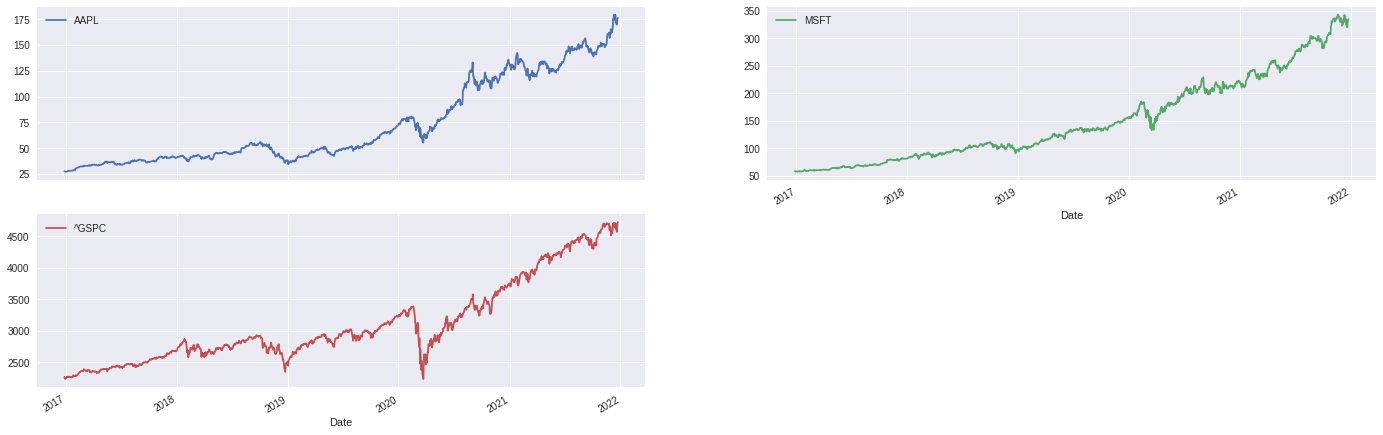

In [3]:
df = get_data(path=PATH, stocks=stocks, fetch=True)

df.plot(figsize=(24, 12), subplots=True, layout=(3, 2))

array([[<AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'MSFT'}>],
       [<AxesSubplot:title={'center':'^GSPC'}>, <AxesSubplot:>]],
      dtype=object)

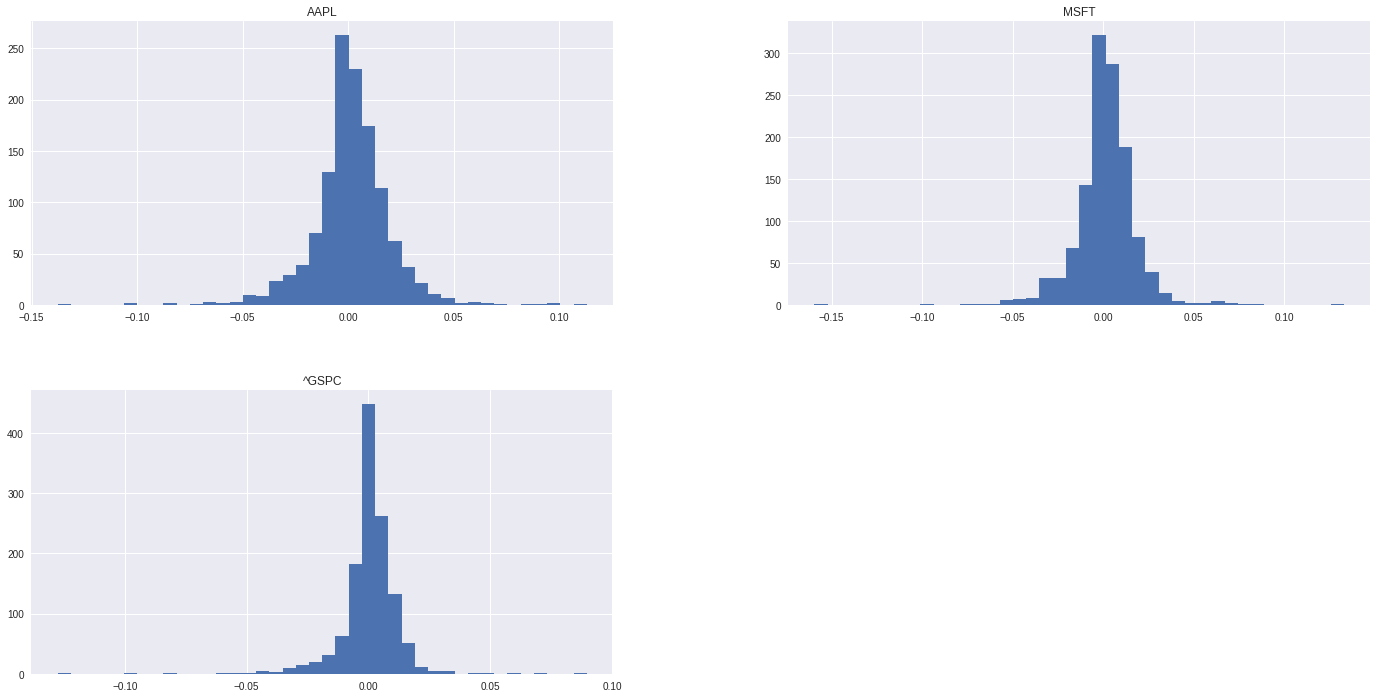

In [4]:
returns = np.log(df / df.shift(1))

returns.hist(bins=40, figsize=(24, 12))

In [5]:
returns.mean() * 252

Symbols
AAPL     0.371783
MSFT     0.348519
^GSPC    0.147100
dtype: float64

In [6]:
returns.cov() * 252

Symbols,AAPL,MSFT,^GSPC
Symbols,,,
AAPL,0.092862,0.062003,0.044987
MSFT,0.062003,0.075638,0.044505
^GSPC,0.044987,0.044505,0.037434


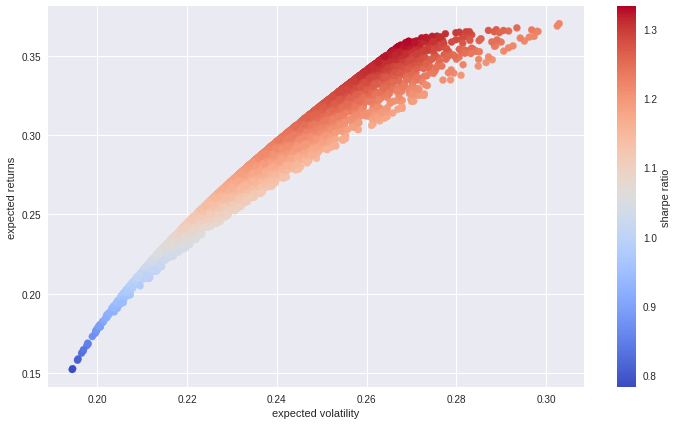

In [7]:
def portfolio_returns(weights):
    return np.sum(returns.mean() * weights) * 252
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

prets = []
pvols = []
for p in range(5000):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    prets.append(portfolio_returns(weights))
    pvols.append(portfolio_volatility(weights))
    
prets = np.array(prets)
pvols = np.array(pvols)

plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=prets/pvols, marker='o', cmap='coolwarm')
plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

## Find best weights

In [8]:
import scipy.optimize as sco

def min_sharpe(weights):
    return -portfolio_returns(weights) / portfolio_volatility(weights)

cons = ({
    'type': 'eq',
    'fun': lambda x: np.sum(x) - 1
})
bnds = tuple((0, 1) for _ in range(len(stocks)))
eweights = np.array(len(stocks) * [1. / len(weights)])
print(min_sharpe(eweights))

-1.2158892283369636


### Weights with max Sharpe ratio

In [9]:
opts = sco.minimize(
    min_sharpe,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)
for ticker, weight in zip(stocks, opts["x"].round(3)):
    if weight:
        print(f"{ticker}: {weight}")
print('returns', portfolio_returns(opts['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(opts['x']))
print('sharpe ratio', portfolio_returns(opts['x']) / portfolio_volatility(opts['x']))

AAPL: 0.411
MSFT: 0.589
returns 35.809000000000005 %
volatility 0.2682335983037531
sharpe ratio 1.334990282916571


### Weights with minimum volatility

In [10]:
optv = sco.minimize(
    portfolio_volatility,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)
for ticker, weight in zip(stocks, opts["x"].round(3)):
    if weight:
        print(f"{ticker}: {weight}")
print('returns', portfolio_returns(optv['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(optv['x']))
print('sharpe ratio', portfolio_returns(optv['x']) / portfolio_volatility(optv['x']))

AAPL: 0.411
MSFT: 0.589
returns 14.71 %
volatility 0.19347904798400373
sharpe ratio 0.7602887055248885


### Efficient frontier

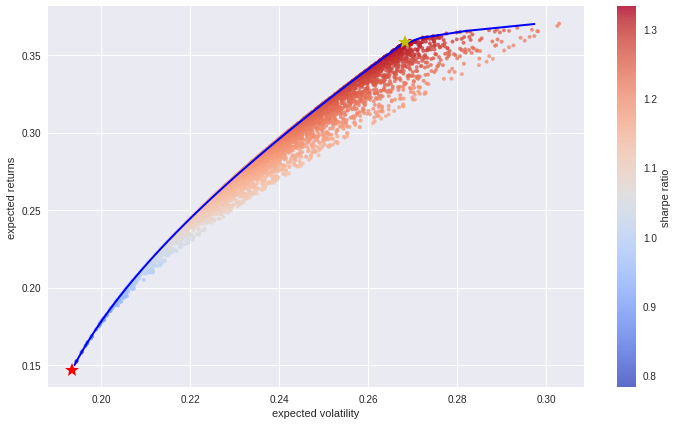

In [11]:
cons = (
    { 'type': 'eq', 'fun': lambda x: portfolio_returns(x) - tret},
    { 'type': 'eq', 'fun': lambda x: np.sum(x) - 1 }
)
bnds = tuple((0, 1) for _ in range(len(stocks)))

target_rets = np.linspace(0.15, 0.37, 50)
target_vols = []

for tret in target_rets:
    res = sco.minimize(
        portfolio_volatility,
        eweights,
        method='SLSQP',
        bounds=bnds,
        constraints=cons
    )
    target_vols.append(res['fun'])
target_vols = np.array(target_vols)
plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=prets/pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(target_vols, target_rets, 'b', lw=2.0)
plt.plot(portfolio_volatility(opts['x']), portfolio_returns(opts['x']), 'y*', markersize=15.0)
plt.plot(portfolio_volatility(optv['x']), portfolio_returns(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

### Capital market line

In [12]:
import scipy.interpolate as sci

ind = np.argmin(target_vols)
evols = target_vols[ind:]
erets = target_rets[ind:]

tck = sci.splrep(evols, erets)

def f(x):
    """ Efficient frontier function (splines approximation). """
    return sci.splev(x, tck, der=0)
def df(x):
    """ First derivative of efficient frontier function. """
    return sci.splev(x, tck, der=1)
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.5, 0.15])
opt

array([0.01      , 1.29704544, 0.26847523])

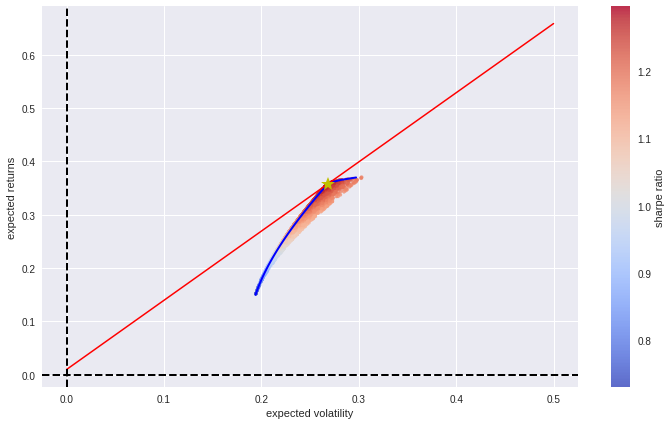

In [13]:
plt.figure(figsize=(12, 7))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols, marker='.', alpha=0.8, cmap='coolwarm')
plt.plot(evols, erets, 'b', lw=2.0)

cx = np.linspace(0.0, 0.5)
plt.plot(cx, opt[0] + opt[1] * cx, 'r', lw=1.5)
plt.plot(opt[2], f(opt[2]), 'y*', markersize=15.0)
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)

plt.xlabel('expected volatility')
plt.ylabel('expected returns')
plt.colorbar(label='sharpe ratio')

In [14]:
cons = (
    { 'type': 'eq', 'fun': lambda x: portfolio_returns(x) - f(opt[2])},
    { 'type': 'eq', 'fun': lambda x: np.sum(x) - 1 }
)
bnds = tuple((0, 1) for _ in range(len(stocks)))


res = sco.minimize(
    portfolio_volatility,
    eweights,
    method='SLSQP',
    bounds=bnds,
    constraints=cons
)

for ticker, weight in zip(stocks, opts["x"].round(3)):
    if weight:
        print(f"{ticker}: {weight}")
print('returns', portfolio_returns(res['x']).round(5) * 100, '%')
print('volatility', portfolio_volatility(res['x']))
print('sharpe ratio', portfolio_returns(res['x']) / portfolio_volatility(res['x']))

AAPL: 0.411
MSFT: 0.589
returns 35.821999999999996 %
volatility 0.26833763999917065
sharpe ratio 1.334976955819719
